# Telecom Churn Prediction Pipeline

* [Kaggle Dataset](https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics)
* [How to Use Kaggle](https://www.kaggle.com/docs/api)

In [ ]:
import pandas as pd
import kagglehub as kh

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

from kagglehub import KaggleDatasetAdapter

# Importing the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Importing Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Maven Analytics Datasets
[Dataset Source](https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics)

In [105]:
df = kh.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "shilongzhuang/telecom-customer-churn-by-maven-analytics",
    "telecom_customer_churn.csv"
)

df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


### Load the Population DF
The file `telecom_zipcode_population.csv` contains population data corresponding to individual ZIP codes.

In [106]:
population_df = kh.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "shilongzhuang/telecom-customer-churn-by-maven-analytics",
    "telecom_zipcode_population.csv"
)

population_df.head()

,Zip Code,Population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


### Renaming the Columns
Converting all column names to lower letters and replacing spaces with underscores.

In [107]:
df = df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns')

# Converting all column names to lower letters and replacing spaces with underscores.
population_df = population_df.rename(
    lambda x: x.lower().strip().replace(' ', '_'),
    axis="columns"
)

df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [108]:
# And now the population dataframe
population_df.head()

,zip_code,population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


## Data Exploration

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   married                            7043 non-null   object 
 4   number_of_dependents               7043 non-null   int64  
 5   city                               7043 non-null   object 
 6   zip_code                           7043 non-null   int64  
 7   latitude                           7043 non-null   float64
 8   longitude                          7043 non-null   float64
 9   number_of_referrals                7043 non-null   int64  
 10  tenure_in_months                   7043 non-null   int64  
 11  offer                              3166 non-null   objec

In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
number_of_dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
zip_code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
number_of_referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
tenure_in_months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
avg_monthly_long_distance_charges,6361.0,25.420517,14.200374,1.010000,13.050000,25.690000,37.680000,49.990000
avg_monthly_gb_download,5517.0,26.189958,19.586585,2.000000,13.000000,21.000000,30.000000,85.000000
monthly_charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000


### Plotting the output `customer_status` Values
I will plot the Customer Status Values using the Seaborn Library

In [111]:
# Checking the Unique Values for the customer_status column
df.customer_status.unique()

array(['Stayed', 'Churned', 'Joined'], dtype=object)

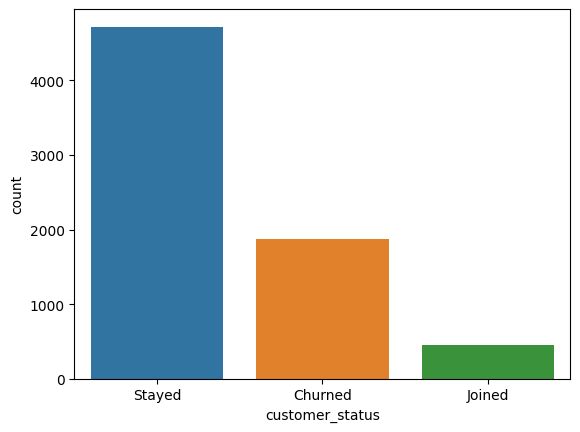

In [112]:
# Plotting the value distribution of the customer_status column.
sns.countplot(df, x="customer_status", hue="customer_status")
plt.show()

### Checking for Null Values
It's common for real-world datasets to include missing values. Properly identifying and processing these missing entries is a crucial step in data preprocessing to maintain model accuracy and reliability.

In [113]:
df.isnull().sum()

customer_id                             0
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenure_in_months                        0
offer                                3877
phone_service                           0
avg_monthly_long_distance_charges     682
multiple_lines                        682
internet_service                        0
internet_type                        1526
avg_monthly_gb_download              1526
online_security                      1526
online_backup                        1526
device_protection_plan               1526
premium_tech_support                 1526
streaming_tv                         1526
streaming_movies                  

### Checking if the nulls overlap
I have several columns with the same amount of missing values (1526). I need to check if those rows overlap.

In [114]:
df[df["internet_type"].isnull()][[
    "internet_type",
    "avg_monthly_gb_download",
    "online_security",
    "online_backup",
    "device_protection_plan",
    "premium_tech_support",
    "streaming_tv",
    "streaming_movies",
    "streaming_music",
    "unlimited_data"
]]

,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This confirms my suspicion that this data doesn't exist for any of the customers. I need to do the same for `avg_monthly_long_distance_charges` and `multiple_lines`. They both have the same number of missing values - 682.

In [115]:
df[df["avg_monthly_long_distance_charges"].isnull()][[
    "avg_monthly_long_distance_charges",
    "multiple_lines"
]]

,avg_monthly_long_distance_charges,multiple_lines
10,NaN,NaN
14,NaN,NaN
16,NaN,NaN
19,NaN,NaN
25,NaN,NaN
...,...,...
6979,NaN,NaN
6980,NaN,NaN
6996,NaN,NaN
7016,NaN,NaN


### Checking Unique Values for Every Column Containing Null Values

In [116]:
for col in df.columns[df.isnull().any()]:
    print(f"\nColumn: {col}")
    print(df[col].dropna().unique())


Column: offer
['Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']

Column: avg_monthly_long_distance_charges
[42.39 10.69 33.65 ... 10.04 25.59  2.01]

Column: multiple_lines
['No' 'Yes']

Column: internet_type
['Cable' 'Fiber Optic' 'DSL']

Column: avg_monthly_gb_download
[16. 10. 30.  4. 11. 73. 14.  7. 21. 59. 19. 12. 20. 22. 17.  9. 52. 57.
 51. 41. 23. 27.  2. 69. 53. 15. 29. 85. 28. 18. 48. 25. 26.  8.  6.  5.
 13. 75. 82. 24. 76. 47. 71. 58. 42.  3. 56. 46. 39.]

Column: online_security
['No' 'Yes']

Column: online_backup
['Yes' 'No']

Column: device_protection_plan
['No' 'Yes']

Column: premium_tech_support
['Yes' 'No']

Column: streaming_tv
['Yes' 'No']

Column: streaming_movies
['No' 'Yes']

Column: streaming_music
['No' 'Yes']

Column: unlimited_data
['Yes' 'No']

Column: churn_category
['Competitor' 'Dissatisfaction' 'Other' 'Price' 'Attitude']

Column: churn_reason
['Competitor had better devices' 'Product dissatisfaction'
 'Network reliability' 'Limited range of services

## Data Pre-processing & Cleaning



### Replacing `zip_code` Column With `population` Data
Since population is a more informative feature for the model, I will replace the `zip_code` column with the `population` value associated with each ZIP code.

In [117]:
# Merge df with population_df on 'zip_code'
df = df.merge(population_df, on="zip_code", how="left")

# Get current columns list
cols = df.columns.tolist()

# Remove 'city_encoded' from current position
cols.remove("population")

# Find index of 'city' column
insertion_index = cols.index("city") + 1

# Insert 'city_encoded' after 'city'
cols.insert(insertion_index, "population")

# Reorder DataFrame columns
df = df[cols]

df.head()

,customer_id,gender,age,married,number_of_dependents,city,population,zip_code,latitude,longitude,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,4498,93225,34.827662,-118.999073,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,31297,91206,34.162515,-118.203869,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,62069,92627,33.645672,-117.922613,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,46677,94553,38.014457,-122.115432,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,42853,93010,34.227846,-119.079903,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


### Cleaning up the DataFrame
As part of the preprocessing step, we need to remove columns that are not useful or potentially harmful for the churn prediction task. Specifically, the following columns are dropped:

  1. `customer_id` – A unique identifier that provides no predictive value; it doesn't contain any pattern related to churn.
  2. `latitude` & `longitude` – While they represent geographic information, raw coordinates typically offer limited predictive value. In this case, they are excluded to reduce noise, and because they are redundant to the `zip_code` and the `city` columns.
  3. `churn_category` - This is a post-churn diagnostic label describing the churn category.  
  4. `churn_reason` - This is a post-churn diagnostic label describing why the customer has decided to leave the Telecom.
  5. `zip_code` - We have already replaced the ZIP code column with the respective population data from the `telecom_zipcode_population.csv`.

By removing these features, we ensure that the model learns from generalizable, predictive features without relying on identifiers or outcome-dependent information.

In [ ]:
df = df.drop(columns = [
    "customer_id",
    "latitude",
    "longitude",
    "churn_category",
    "churn_reason",
    "zip_code"
])

# Checking the number of columns
df.head()

,gender,age,married,number_of_dependents,city,population,number_of_referrals,tenure_in_months,offer,phone_service,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status
0,Female,37,Yes,0,Frazier Park,4498,2,9,NaN,Yes,...,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed
1,Male,46,No,0,Glendale,31297,0,9,NaN,Yes,...,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed
2,Male,50,No,0,Costa Mesa,62069,0,4,Offer E,Yes,...,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned
3,Male,78,Yes,0,Martinez,46677,1,13,Offer D,Yes,...,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned
4,Female,75,Yes,0,Camarillo,42853,3,3,NaN,Yes,...,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned


### Dealing with Missing Values
We can safely ignore the churn_category and churn_reason columns, as they represent post-churn classifications. Including them would introduce data leakage into our churn prediction model, since they are only known after a customer has already churned.

Regarding the remaining missing values, they appear in a small subset—10 rows out of 1,526—which suggests limited impact on overall data quality. Based on their pattern, it is likely these entries correspond to early customers or inactive accounts with incomplete service data.

To handle these missing values, we will replace them with the most logical defaults:

  * `No` for binary categories, that contain only `Yes` and `No` values.

  * `0` for numerical fields

  * a placeholder category like `No Offer` or `No Internet` to explicitly account for the absence of information for the missing values in the `offer` and `internet_type` categorical columns.

This ensures the model receives consistent input without introducing misleading assumptions.

#### Creating a Simple Function for Custom Missing Value Imputation

In [119]:
def replace_nans(df, col_list, value):
    """
    Replace missing values in specified columns of a DataFrame with a given value.

    Parameters:
        df (pd.DataFrame): The DataFrame to process.
        col_list (list of str): List of column names to fill NaNs in.
        value: The value to replace NaNs with.

    Returns:
        pd.DataFrame: DataFrame with NaNs replaced in the specified columns.
    """
    for col in col_list:
        df[col] = df[col].fillna(value)
    return df

#### Replacing the Missing Values of the Categorical Columns
Replacing the NaNs with placeholder values indicating that we have no information for those fields.

In [120]:
categorical_cols_with_nans = [
    "internet_type",
    "offer"
]

df = replace_nans(df, categorical_cols_with_nans, "Missing")

#### Replacing the Missing Values of Binary Columns
Missing values in binary categorical columns were replaced with 'No', under the assumption that null entries indicate the service was not subscribed to or the feature was unavailable.

In [121]:
binary_cols_with_nans = [
    "multiple_lines",
    "online_security",
    "online_backup",
    "device_protection_plan",
    "premium_tech_support",
    "streaming_tv",
    "streaming_movies",
    "streaming_music",
    "unlimited_data"
]

df = replace_nans(df, binary_cols_with_nans, "No")

#### Replacing NaN Values in Numerical Columns
We will replace the missing values with 0 in the numerical columns:
* `avg_monthly_long_distance_charges`
* `avg_monthly_gb_download`

In [122]:
numerical_cols_with_nans = [
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download"
]

df = replace_nans(df, numerical_cols_with_nans, 0)

#### Checking again for NaNs


In [123]:
df.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
city                                 0
population                           0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method           

## Encoding Binary and Categorical Features

### Converting the Binary Columns using Label Encoder
We will identify all columns in the DataFrame that contain binary string values (e.g., "Yes" or "No") which are suitable candidates for encoding with a Label Encoder and use it to convert them into a binary numerical values.

In [124]:
binary_string_cols = []

for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) == 2 and all(isinstance(val, str) for val in unique_vals):
        binary_string_cols.append(col)

# Encode each column with a LabelEncoder instance
for col in binary_string_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

df.head()

,gender,age,married,number_of_dependents,city,population,number_of_referrals,tenure_in_months,offer,phone_service,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status
0,0,37,1,0,Frazier Park,4498,2,9,Missing,1,...,One Year,1,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed
1,1,46,0,0,Glendale,31297,0,9,Missing,1,...,Month-to-Month,0,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed
2,1,50,0,0,Costa Mesa,62069,0,4,Offer E,1,...,Month-to-Month,1,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned
3,1,78,1,0,Martinez,46677,1,13,Offer D,1,...,Month-to-Month,1,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned
4,0,75,1,0,Camarillo,42853,3,3,Missing,1,...,Month-to-Month,1,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned


#### Applying LabelEncoder on our Target Variable
For random forest classification we ned to convert our target variable (`customer_status`) into numerical values.

In [125]:
le = LabelEncoder()

df["customer_status"] = le.fit_transform(df["customer_status"])

list(zip(le.classes_, le.transform(le.classes_)))

[('Churned', np.int64(0)), ('Joined', np.int64(1)), ('Stayed', np.int64(2))]

### Analyzing the Cardinality of the city Feature
Checking the number of unique values in a categorical feature like `city` is crucial before choosing an encoding strategy. High-cardinality columns (i.e., those with many unique values) can lead to excessive dimensionality if one-hot encoded, which can increase model complexity, slow down training, and potentially cause overfitting. By checking uniqueness, we can decide whether simpler alternatives like frequency encoding or target encoding would be more effective.

In [126]:
df["city"].nunique()

1106

I will apply frequency encoding for the `city`, replacing each city with the number of times it appears in the dataset.

In [127]:
city_freq = df["city"].value_counts()
df["city_encoded"] = df["city"].map(city_freq)

df["city_encoded"].head()

0     8
1    40
2     8
3     4
4     8
Name: city_encoded, dtype: int64

In [128]:
# Get current columns list
cols = df.columns.tolist()

# Remove 'city_encoded' from current position
cols.remove("city_encoded")

# Find index of 'city' column
insertion_index = cols.index("city") + 1

# Insert 'city_encoded' after 'city'
cols.insert(insertion_index, "city_encoded")

# Reorder DataFrame columns
df = df[cols]

# Now drop the original 'city' column
df = df.drop(columns=["city"])

df.head()

,gender,age,married,number_of_dependents,city_encoded,population,number_of_referrals,tenure_in_months,offer,phone_service,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status
0,0,37,1,0,8,4498,2,9,Missing,1,...,One Year,1,Credit Card,65.6,593.30,0.00,0,381.51,974.81,2
1,1,46,0,0,40,31297,0,9,Missing,1,...,Month-to-Month,0,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,2
2,1,50,0,0,8,62069,0,4,Offer E,1,...,Month-to-Month,1,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,0
3,1,78,1,0,4,46677,1,13,Offer D,1,...,Month-to-Month,1,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,0
4,0,75,1,0,8,42853,3,3,Missing,1,...,Month-to-Month,1,Credit Card,83.9,267.40,0.00,0,22.14,289.54,0


### Encoding Categorical Features with OneHotEncoder

The remaining categorical features have a relatively low number of unique values and it is safe to apply OneHotEncoder for their features. This method creates binary indicator columns for each category, allowing the model to interpret categorical data without imposing any ordinal relationship.

In [129]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.head()

,gender,age,married,number_of_dependents,city_encoded,population,number_of_referrals,tenure_in_months,phone_service,avg_monthly_long_distance_charges,...,offer_Offer C,offer_Offer D,offer_Offer E,internet_type_DSL,internet_type_Fiber Optic,internet_type_Missing,contract_One Year,contract_Two Year,payment_method_Credit Card,payment_method_Mailed Check
0,0,37,1,0,8,4498,2,9,1,42.39,...,False,False,False,False,False,False,True,False,True,False
1,1,46,0,0,40,31297,0,9,1,10.69,...,False,False,False,False,False,False,False,False,True,False
2,1,50,0,0,8,62069,0,4,1,33.65,...,False,False,True,False,True,False,False,False,False,False
3,1,78,1,0,4,46677,1,13,1,27.82,...,False,True,False,False,True,False,False,False,False,False
4,0,75,1,0,8,42853,3,3,1,7.38,...,False,False,False,False,True,False,False,False,True,False


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   age                                7043 non-null   int64  
 2   married                            7043 non-null   int64  
 3   number_of_dependents               7043 non-null   int64  
 4   city_encoded                       7043 non-null   int64  
 5   population                         7043 non-null   int64  
 6   number_of_referrals                7043 non-null   int64  
 7   tenure_in_months                   7043 non-null   int64  
 8   phone_service                      7043 non-null   int64  
 9   avg_monthly_long_distance_charges  7043 non-null   float64
 10  multiple_lines                     7043 non-null   int64  
 11  internet_service                   7043 non-null   int64

### Splitting the Datasets into Small & Full
Splitting the Dataset into:
* `df_small` - Small dataset containing only 1000 entries.
* `df_full` - The full dataset contaiing all 7043 entries.

In [146]:
df_small = df.sample(n=1000, random_state=42)

df_full = df.copy()

## Random Forest Training with MLflow Logging
Trains a Random Forest classifier on a given dataset, logs hyperparameters, performance metrics (accuracy, precision, recall, F1-score, AUC), and visual artifacts (feature importance, confusion matrix) to an MLflow tracking server. Supports configurable model parameters and automatically distinguishes between small and full datasets for run naming.

In [ ]:
def train_random_forest_classifier(
        dataset, 
        n_estimators, 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features="sqrt", 
        criterion="gini"
    ):
    
    def get_dataset_name(dataset, small_threshold=1000):
        return "Small Dataset" if dataset.shape[0] <= small_threshold else "Full Dataset"
    
    dataset_name = get_dataset_name(dataset)

    # Convert all int columns to float64 to suppress MLflow Warning
    for col in dataset.columns:
        if pd.api.types.is_integer_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float64")

    # Features and target
    X = dataset.drop(columns=["customer_status"])
    y = dataset["customer_status"]

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Set up MLflow
    mlflow.set_tracking_uri("http://localhost:5000")
    experiment_name = "RF Churn Prediction"
    mlflow.set_experiment(experiment_name)

    run_name = (
        f"{dataset_name} | Estimators={n_estimators}, Depth={max_depth}, "
        f"MinSplit={min_samples_split}, MinLeaf={min_samples_leaf}, "
        f"MaxFeatures={max_features}, Criterion={criterion}"
    )

    with mlflow.start_run(run_name=run_name):
        # Enable autologging before training
        mlflow.autolog()

        # Train model
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            criterion=criterion
        )
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log AUC (handle binary or multiclass)
        if y_proba.shape[1] == 2:
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:
            auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
        mlflow.log_metric("auc", auc)

        # Log classification report metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_name, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric_name}", value)
            elif isinstance(metrics, float):  # "accuracy"
                mlflow.log_metric(label, metrics)

        # Feature importance plot
        importance = pd.Series(model.feature_importances_, index=X.columns)
        importance = importance.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importance, y=importance.index)
        plt.title("Feature Importance (Sorted)")
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        mlflow.log_artifact("feature_importance.png")
        plt.close()

        # Confusion matrix plot
        label_map = [
            "Churned",
            "Joined",
            "Stayed"
        ]

        ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=label_map,
            cmap='Blues'
        )
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig("training_confusion_matrix.png")
        mlflow.log_artifact("training_confusion_matrix.png")
        plt.close()


In [143]:
train_random_forest_classifier(
        df_full, 
        500, 
        None, 
        min_samples_split=5, 
        min_samples_leaf=2, 
        max_features="log2", 
        criterion="entropy"
    )

2025/06/12 21:59:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


🏃 View run Full Dataset | Estimators=500, Depth=None, MinSplit=5, MinLeaf=2, MaxFeatures=log2, Criterion=entropy at: http://localhost:5000/#/experiments/2/runs/c0911f8149ef4b6ba03ee3916cff2140
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [144]:
train_random_forest_classifier(
        df_small, 
        100, 
        None, 
        min_samples_split=2, 
        min_samples_leaf=2, 
        max_features="log2", 
        criterion="gini"
    )

2025/06/12 21:59:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


🏃 View run Small Dataset | Estimators=100, Depth=None, MinSplit=2, MinLeaf=2, MaxFeatures=log2, Criterion=gini at: http://localhost:5000/#/experiments/2/runs/447b42f9121447b2ad3063c39bc1f6e6
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [145]:
train_random_forest_classifier(
        df_small, 
        200
    )

2025/06/12 21:59:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


🏃 View run Small Dataset | Estimators=200, Depth=None, MinSplit=2, MinLeaf=1, MaxFeatures=sqrt, Criterion=gini at: http://localhost:5000/#/experiments/2/runs/1eb3406a0aaa4995895dc1e2ea3e4326
🧪 View experiment at: http://localhost:5000/#/experiments/2
